In [34]:
import random

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.resnet import resnet50

In [36]:
!nvidia-smi



Sat Apr 22 06:15:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   2082MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [37]:
!pip install torch-lr-finder


In [38]:
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1),
        torchvision.transforms.RandomAffine(15),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
valid_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),##imagenet mean and std
])


In [40]:
train_comp_dataset=torchvision.datasets.ImageFolder(root='/kaggle/input/qa-compressed-images/compress_dataset',transform=train_transforms)

val_comp_dataset=torchvision.datasets.ImageFolder(root='/kaggle/input/qa-compressed-images/compress_dataset',transform=valid_transforms)

In [41]:
num_train = len(train_comp_dataset)
indices = list(range(num_train))

num_train

10894

In [42]:
train_comp_dataset.classes

['commercial_air_normal',
 'commercial_air_over',
 'commercial_deep_normal',
 'commercial_deep_over',
 'commercial_unbaked',
 'inhouse_air_normal',
 'inhouse_air_over',
 'inhouse_deep_normal',
 'inhouse_deep_over',
 'inhouse_old_air_normal',
 'inhouse_old_air_over',
 'inhouse_old_deep_normal',
 'inhouse_old_deep_over',
 'inhouse_unbaked']

In [43]:
random.seed(42)

In [44]:
random.shuffle(indices)

In [45]:
indices

[4962,
 3149,
 4146,
 5094,
 7786,
 1705,
 7276,
 2751,
 4275,
 847,
 5299,
 3474,
 7145,
 5059,
 789,
 361,
 6659,
 6189,
 1620,
 6513,
 7157,
 7312,
 3402,
 3064,
 3909,
 9384,
 4243,
 6099,
 7958,
 4256,
 880,
 8981,
 10800,
 552,
 6597,
 169,
 6827,
 5782,
 3825,
 4657,
 10835,
 1999,
 3821,
 2889,
 7037,
 8247,
 3204,
 4263,
 1061,
 4578,
 1722,
 4818,
 10522,
 10544,
 5732,
 7558,
 9484,
 2357,
 8362,
 2432,
 5193,
 3546,
 7365,
 5212,
 3079,
 1432,
 3398,
 8577,
 4537,
 10741,
 1300,
 3754,
 9073,
 5516,
 5603,
 8015,
 6716,
 7782,
 1253,
 10533,
 1699,
 8731,
 5839,
 3577,
 6938,
 9385,
 3729,
 8822,
 3411,
 9425,
 6819,
 1760,
 1830,
 1803,
 4122,
 9870,
 9349,
 10833,
 8662,
 7067,
 5210,
 6476,
 5713,
 7645,
 8857,
 3664,
 6556,
 6308,
 1977,
 5686,
 10665,
 9576,
 3132,
 5777,
 10224,
 6778,
 5450,
 1915,
 3604,
 6534,
 2105,
 4515,
 3061,
 1995,
 5633,
 7274,
 10478,
 9290,
 7628,
 1613,
 10600,
 2020,
 7890,
 3659,
 1222,
 1364,
 6384,
 3008,
 6891,
 10200,
 10341,
 9372,

In [46]:
num_train

10894

In [47]:
len(val_comp_dataset)

10894

In [48]:
# train_indices=indices[:210]
# val_indices=indices[210:260]
# test_indices=indices[260:]

In [49]:
dataset_size = num_train

In [50]:
# Define the ratio of data to keep for training, validation, and testing
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of examples to keep for each split
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

In [51]:
print(train_size)
print(val_size)
print(test_size)

7625
1634
1635


In [52]:
train_size + val_size

9259

In [53]:
train_indices = indices[:train_size]
val_indices = indices[train_size: train_size + val_size]
test_indices = indices[train_size + val_size : ]

In [54]:
print(len(test_indices))

1635


In [55]:
train_dataset = torch.utils.data.Subset(train_comp_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(val_comp_dataset, val_indices)


In [57]:
#batch_size = 32
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size,shuffle=False,num_workers=2,pin_memory=True)


In [58]:
from torchvision.models.resnet import resnet34
#model = resnet50(pretrained=True)
#model_shape = resnet50(pretrained=False)
#model_shape.load_state_dict(torch.load('../input/models-pytorch/Models (1)/resnet50_new_10epochs.pt'))
#model_shape.load_state_dict(torch.load('../input/models-pytorch/Models (1)/resnet50_new_10epochs.pt',map_location=torch.device('cpu')))

In [59]:
model=torch.load('/kaggle/input/models-pytorch/Models (1)/resnet50_new_10epochs.pt')

In [61]:
##For the colour models
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048,512),
    torch.nn.Linear(512,128),
    torch.nn.Linear(128,32),
    torch.nn.Linear(32,14),
    #torch.nn.Linear(8,2)
)

  0%|          | 0/10 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Failed to compute the gradients, there might not be enough points.


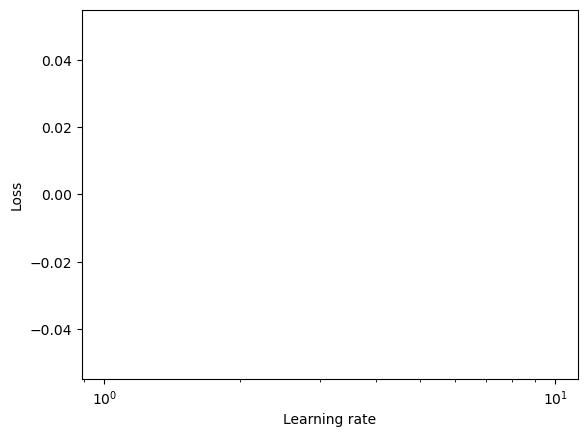

In [62]:
from torch_lr_finder import LRFinder
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader,end_lr=0.05, num_iter=10)
lr_finder.plot()
lr_finder.reset()


In [64]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

In [65]:
cuda = True
epochs = 10
# model_name = '/content/drive/My Drive/resnet50.pt'
model_name = './resnet50_experiment.pt'
optimizer = torch.optim.Adam(model.parameters(),lr=1.00E-03,weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1,patience=1,verbose=True)

writer = SummaryWriter() # For Tensorboard
early_stop_count=0
ES_patience=6
best = 0.0
if cuda:
    model.cuda()

for epoch in range(epochs):
    
    # Training
    model.train()
    correct = 0
    train_loss = 0.0
    tbar = tqdm(train_loader, desc = 'Training', position=0, leave=True)
    for i,(inp,lbl) in enumerate(tbar):
        optimizer.zero_grad()
        if cuda:
            inp,lbl = inp.cuda(),lbl.cuda()
        out = model(inp)
        loss = criterion(out,lbl)
        train_loss += loss
        out = out.argmax(dim=1)
        correct += (out == lbl).sum().item()
        loss.backward()
        optimizer.step()
        tbar.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.5f}, acc: {100.0*correct/((i+1)*train_loader.batch_size):.4f}%")
    train_acc = 100.0*correct/len(train_loader.dataset)
    train_loss /= (len(train_loader.dataset)/batch_size)

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        val_loss = 0.0
        vbar = tqdm(valid_loader, desc = 'Validation', position=0, leave=True)
        for i,(inp,lbl) in enumerate(vbar):
            if cuda:
                inp,lbl = inp.cuda(),lbl.cuda()
            out = model(inp)
            val_loss += criterion(out,lbl)
            out = out.argmax(dim=1)
            correct += (out == lbl).sum().item()
        val_acc = 100.0*correct/len(valid_loader.dataset)
        val_loss /= (len(valid_loader.dataset)/batch_size)
    print(f'\nEpoch: {epoch+1}/{epochs}')
    print(f'Train loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Validation loss: {val_loss}, Validation Accuracy: {val_acc}\n')

    scheduler.step(val_loss)

    # write to tensorboard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    
     # Append the accuracy and loss values to the respective lists
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    

    if val_acc>best:
        best=val_acc
        torch.save(model,model_name)
        early_stop_count=0
        print('Accuracy Improved, model saved.\n')
    else:
        early_stop_count+=1
        
#     if val_acc > 95:
#         best=val_acc
#         torch.save(model,model_name)
#         print(f'Accuracy achieved: {best:.2f}%. Stoppping Early to prevent overtraining.')
#         break

    if early_stop_count==ES_patience:
        print('Early Stopping Initiated...')
        print(f'Best Accuracy achieved: {best:.2f}% at epoch:{epoch-ES_patience}')
        print(f'Model saved as  {model_name}')
        break
    writer.flush()
# writer.close()

Validation: 100%|██████████| 103/103 [00:10<00:00, 10.11it/s]



Epoch: 1/10
Train loss: 0.977475643157959, Train Accuracy: 63.514754098360655
Validation loss: 0.5536348819732666, Validation Accuracy: 79.25336597307222

Accuracy Improved, model saved.



Validation: 100%|██████████| 103/103 [00:10<00:00, 10.10it/s]



Epoch: 2/10
Train loss: 0.5291724801063538, Train Accuracy: 81.35081967213115
Validation loss: 0.3531999886035919, Validation Accuracy: 85.80171358629131

Accuracy Improved, model saved.



Validation: 100%|██████████| 103/103 [00:10<00:00, 10.11it/s]



Epoch: 3/10
Train loss: 0.4084510803222656, Train Accuracy: 85.71803278688525
Validation loss: 0.3440980613231659, Validation Accuracy: 88.31089351285189

Accuracy Improved, model saved.



Validation: 100%|██████████| 103/103 [00:10<00:00,  9.46it/s]



Epoch: 4/10
Train loss: 0.34575068950653076, Train Accuracy: 88.0
Validation loss: 0.29649046063423157, Validation Accuracy: 89.71848225214198

Accuracy Improved, model saved.



Validation: 100%|██████████| 103/103 [00:10<00:00,  9.51it/s]



Epoch: 5/10
Train loss: 0.28700312972068787, Train Accuracy: 89.57377049180327
Validation loss: 0.12963734567165375, Validation Accuracy: 95.34883720930233

Accuracy Improved, model saved.



Validation: 100%|██████████| 103/103 [00:10<00:00, 10.08it/s]



Epoch: 6/10
Train loss: 0.25254127383232117, Train Accuracy: 91.16065573770491
Validation loss: 0.2403814196586609, Validation Accuracy: 91.67686658506732



Validation: 100%|██████████| 103/103 [00:10<00:00,  9.96it/s]



Epoch: 7/10
Train loss: 0.22749502956867218, Train Accuracy: 92.23606557377049
Validation loss: 0.39824843406677246, Validation Accuracy: 87.39290085679315

Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


Validation: 100%|██████████| 103/103 [00:10<00:00, 10.04it/s]



Epoch: 8/10
Train loss: 0.12177985906600952, Train Accuracy: 96.06557377049181
Validation loss: 0.06802672892808914, Validation Accuracy: 97.98041615667074

Accuracy Improved, model saved.



Validation: 100%|██████████| 103/103 [00:10<00:00,  9.57it/s]



Epoch: 9/10
Train loss: 0.08970244228839874, Train Accuracy: 97.11475409836065
Validation loss: 0.05475778505206108, Validation Accuracy: 98.1640146878825

Accuracy Improved, model saved.



Validation: 100%|██████████| 103/103 [00:10<00:00, 10.11it/s]



Epoch: 10/10
Train loss: 0.07476001977920532, Train Accuracy: 97.6
Validation loss: 0.047791317105293274, Validation Accuracy: 98.531211750306

Accuracy Improved, model saved.



In [77]:
# train_loss_list = list(map(lambda x: x.item(), train_loss_list))
val_loss_list = list(map(lambda x: x.item(), val_loss_list))

In [78]:
print(train_acc_list)
print(val_acc_list)
print(train_loss_list)
print(val_loss_list)

[63.514754098360655, 81.35081967213115, 85.71803278688525, 88.0, 89.57377049180327, 91.16065573770491, 92.23606557377049, 96.06557377049181, 97.11475409836065, 97.6]
[79.25336597307222, 85.80171358629131, 88.31089351285189, 89.71848225214198, 95.34883720930233, 91.67686658506732, 87.39290085679315, 97.98041615667074, 98.1640146878825, 98.531211750306]
[0.977475643157959, 0.5291724801063538, 0.4084510803222656, 0.34575068950653076, 0.28700312972068787, 0.25254127383232117, 0.22749502956867218, 0.12177985906600952, 0.08970244228839874, 0.07476001977920532]
[0.5536348819732666, 0.3531999886035919, 0.3440980613231659, 0.29649046063423157, 0.12963734567165375, 0.2403814196586609, 0.39824843406677246, 0.06802672892808914, 0.05475778505206108, 0.047791317105293274]


In [85]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 15.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Plotting accuracy and loss graphs
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(train_acc_list)+1)), y=train_acc_list, mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, len(val_acc_list)+1)), y=val_acc_list, mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Accuracy Graph', xaxis_title='Epochs', yaxis_title='Accuracy')
fig.show()
pio.write_image(fig, 'plots/accuracy_plot.png')

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(train_loss_list)+1)), y=train_loss_list, mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, len(val_loss_list)+1)), y=val_loss_list, mode='lines', name='Validation Loss'))
fig.update_layout(title='Loss Graph', xaxis_title='Epochs', yaxis_title='Loss')
fig.show()
pio.write_image(fig_acc, 'plots/accuracy_plot.png')

In [ ]:
for i,param in enumerate(model.parameters()):
    if i<120:
        param.requires_grad=True

In [ ]:
epochs_non_freezing= 20
early_stop_count=0
for epoch in range(epochs_non_freezing):
    
    # Training
    model.train()
    correct = 0
    train_loss = 0.0
    tbar = tqdm(train_loader, desc = 'Training', position=0, leave=True)
    for i,(inp,lbl) in enumerate(tbar):
        optimizer.zero_grad()
        if cuda:
            inp,lbl = inp.cuda(),lbl.cuda()
        out = model(inp)
        loss = criterion(out,lbl)
        train_loss += loss
        out = out.argmax(dim=1)
        correct += (out == lbl).sum().item()
        loss.backward()
        optimizer.step()
        tbar.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.5f}, acc: {100.0*correct/((i+1)*train_loader.batch_size):.4f}%")
    train_acc = 100.0*correct/len(train_loader.dataset)
    train_loss /= (len(train_loader.dataset)/batch_size)

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        val_loss = 0.0
        vbar = tqdm(valid_loader, desc = 'Validation', position=0, leave=True)
        for i,(inp,lbl) in enumerate(vbar):
            if cuda:
                inp,lbl = inp.cuda(),lbl.cuda()
            out = model(inp)
            val_loss += criterion(out,lbl)
            out = out.argmax(dim=1)
            correct += (out == lbl).sum().item()
        val_acc = 100.0*correct/len(valid_loader.dataset)
        val_loss /= (len(valid_loader.dataset)/batch_size)
    print(f'\nEpoch: {epoch+1}/{epochs}')
    print(f'Train loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Validation loss: {val_loss}, Validation Accuracy: {val_acc}\n')

    scheduler.step(val_loss)

    # write to tensorboard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    if val_acc>best:
        best=val_acc
        torch.save(model,model_name)
        early_stop_count=0
        print('Accuracy Improved, model saved.\n')
    else:
        early_stop_count+=1
        
    if val_acc > 95:
        best=val_acc
        torch.save(model,model_name)
        print(f'Accuracy achieved: {best:.2f}%. Stoppping Early to prevent overtraining.')
        break

    if early_stop_count==ES_patience:
        print('Early Stopping Initiated...')
        print(f'Best Accuracy achieved: {best:.2f}% at epoch:{epoch-ES_patience}')
        print(f'Model saved as  {model_name}')
        break
    writer.flush()


In [ ]:

%load_ext tensorboard
%tensorboard --logdir logs

In [87]:
trained_model = torch.load('/kaggle/input/resnet50-experiment/resnet50_experiment.pt')

In [ ]:
print(trained_model)

In [88]:
print(len(test_indices))

1635


In [90]:
test_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [91]:
train_comp_dataset=torchvision.datasets.ImageFolder(root='/kaggle/input/qa-compressed-images/compress_dataset', transform = test_transform)
test_dataset = torch.utils.data.Subset(train_comp_dataset, test_indices)
batch_size = 1
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=False,num_workers=2,pin_memory=True)

In [92]:
print(len(test_dataset))

1635


In [93]:
# Iterate over the test dataset using the test data loader
correct = 0
total = 0
misclassified_images = []  # Store misclassified images
correctly_classified = []

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use GPU
else:
    device = torch.device('cpu')   # Use CPU

trained_model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Inference Progress'):
        # Move images and labels to the appropriate device (e.g., GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = trained_model(images)
        
        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Check for misclassified images
        for i in range(images.size(0)):
            if predicted[i] != labels[i]:
                # Append the misclassified image to the list
                misclassified_images.append([images[i], predicted[i], labels[i]])
            else:
                correctly_classified.append([images[i], predicted[i], labels[i]])
                
print('Final Correctly Predicted: ', correct, 'Out of Total: ', total)
accuracy = 100 * correct / total
print('Final Accuracy on test dataset: {:.2f}%'.format(accuracy))

Inference Progress: 100%|██████████| 1635/1635 [00:28<00:00, 57.83it/s]

Final Correctly Predicted:  1547 Out of Total:  1635
Final Accuracy on test dataset: 94.62%


In [ ]:
invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [ ]:
# Display misclassified images
all_classes  = train_comp_dataset.classes

predicted_classes = []
true_classes = []

for i, image_info in enumerate(misclassified_images):
#     plt.imshow(invTrans(image_info[0]).permute(1, 2, 0).cpu().numpy())  # Convert tensor to NumPy array and permute dimensions
#     plt.imshow(image_info[0].permute(1, 2, 0).cpu().numpy())
#     plt.title(f'Misclassified Image {i+1}')
#     print('Predicted: ', all_classes[image_info[1].item()], 'True: ', all_classes[image_info[2].item()])
    predicted_classes.append(all_classes[image_info[1].item()])
    true_classes.append(all_classes[image_info[2].item()])
#     plt.show()
#     if( i == 10):
#         break
        


In [ ]:
# Display misclassified images
all_classes  = train_comp_dataset.classes

for i, image_info in enumerate(correctly_classified):
#     plt.imshow(invTrans(image_info[0]).permute(1, 2, 0).cpu().numpy())  # Convert tensor to NumPy array and permute dimensions
#     plt.imshow(image_info[0].permute(1, 2, 0).cpu().numpy())
#     plt.title(f'Classified Image {i+1}')
#     print('Predicted: ', all_classes[image_info[1].item()], 'True: ', all_classes[image_info[2].item()])
    predicted_classes.append(all_classes[image_info[1].item()])
    true_classes.append(all_classes[image_info[2].item()])
#     plt.show()
#     if( i == 10):
#         break